In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy
import glob
from omegaconf import OmegaConf
import seaborn as sns
import cmweather
import torch

import cartopy.feature as cfeature
import cartopy.crs as ccrs

from zeus.configs.util import instantiate_from_config
from tqdm import tqdm
import inference_earthnet

## Load Model

In [2]:
cfg_file = './multimodal_earth.yaml'
runner = inference_earthnet.EarthNetRunner(cfg_file)

/global/homes/t/tvandal/miniconda3/envs/zeus/lib/python3.10/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Restored from checkpoints/earthnet.v1.ckpt
model initialized


## Load Test Set

In [3]:
data_files = glob.glob('./data/GEO-ATMS-VIIRS-MIRS/test/*.zarr')
ds = [xr.open_zarr(f) for f in data_files[:1]][0]
ds = ds.isel(time=slice(0,12))#.sel(lat=slice(0, 80), lon=slice(-150, 0))
ds

<xarray.Dataset> Size: 9GB
Dimensions:                (Channel: 22, atms_channel: 22, time: 12, lat: 1125,
                            lon: 2249, gk2a_band: 10, goes16_band: 10,
                            goes18_band: 10, mirs_img_Channel: 3,
                            mirs_snd_temp_level: 37, mirs_snd_vapor_level: 37,
                            seviri_band: 9)
Coordinates:
  * Channel                (Channel) int64 176B 0 1 2 3 4 5 ... 17 18 19 20 21
  * atms_channel           (atms_channel) int64 176B 1 2 3 4 5 ... 19 20 21 22
  * gk2a_band              (gk2a_band) int64 80B 7 8 9 10 11 12 13 14 15 16
  * goes16_band            (goes16_band) int64 80B 7 8 9 10 11 12 13 14 15 16
  * goes18_band            (goes18_band) int64 80B 7 8 9 10 11 12 13 14 15 16
  * lat                    (lat) float64 9kB -90.08 -89.92 -89.76 ... 89.6 89.76
  * lon                    (lon) float64 18kB -180.0 -179.8 ... 179.5 179.7
  * mirs_img_Channel       (mirs_img_Channel) int64 24B 0 1 2
  * mirs_snd_temp_level    (mirs_snd_temp_level) float32 148B 986.1 ... 0.975
  * mirs_snd_vapor_level   (mirs_snd_vapor_level) float32 148B 986.1 ... 0.975
  * seviri_band            (seviri_band) <U6 216B 'WV_062' 'WV_073' ... 'IR_134'
  * time                   (time) datetime64[ns] 96B 2024-02-01 ... 2024-02-0...
Data variables: (12/24)
    atms_brightness_temp   (atms_channel, time, lat, lon) float16 1GB dask.array<chunksize=(22, 6, 500, 500), meta=np.ndarray>
    gk2a_Rad               (gk2a_band, time, lat, lon) float16 607MB dask.array<chunksize=(10, 6, 500, 500), meta=np.ndarray>
    goes16_Rad             (goes16_band, time, lat, lon) float16 607MB dask.array<chunksize=(10, 6, 500, 500), meta=np.ndarray>
    goes18_Rad             (goes18_band, time, lat, lon) float16 607MB dask.array<chunksize=(10, 6, 500, 500), meta=np.ndarray>
    mirs_img_CLW           (time, lat, lon) float16 61MB dask.array<chunksize=(6, 500, 500), meta=np.ndarray>
    mirs_img_Emis          (mirs_img_Channel, time, lat, lon) float16 182MB dask.array<chunksize=(3, 6, 500, 500), meta=np.ndarray>
    ...                     ...
    viirs_M11              (time, lat, lon) float16 61MB dask.array<chunksize=(6, 500, 500), meta=np.ndarray>
    viirs_M12              (time, lat, lon) float16 61MB dask.array<chunksize=(6, 500, 500), meta=np.ndarray>
    viirs_M13              (time, lat, lon) float16 61MB dask.array<chunksize=(6, 500, 500), meta=np.ndarray>
    viirs_M14              (time, lat, lon) float16 61MB dask.array<chunksize=(6, 500, 500), meta=np.ndarray>
    viirs_M15              (time, lat, lon) float16 61MB dask.array<chunksize=(6, 500, 500), meta=np.ndarray>
    viirs_M16              (time, lat, lon) float16 61MB dask.array<chunksize=(6, 500, 500), meta=np.ndarray>

## Run Model

In [4]:
inputs = runner.prepare_inputs(ds)
print(inputs.keys())

dict_keys(['mirs_img', 'mirs_snd_temp', 'mirs_snd_vapor', 'mirs_rain', 'goes16', 'goes18', 'gk2a', 'seviri', 'atms', 'viirs', 'srtm'])


In [5]:
# Filter inputs you'd like to ignore

#inputs['goes16'][:] = np.nan
#inputs['goes18'][:] = np.nan
#inputs['gk2a'][:] = np.nan
#inputs['seviri'][:] = np.nan
#inputs['atms'][:] = np.nan
#inputs['srtm'][:] = np.nan
#inputs['viirs'][:] = np.nan


for k, v in inputs.items():
#    Remove last timestep
#    if len(v.shape) == 5:
#        print(k, v.shape)
#        inputs[k][:,:,-1:] = np.nan

    # Remove MIRS data from infernece
    if 'mirs' in k:
        print(k)
        inputs[k][:] = np.nan


mirs_img
mirs_snd_temp
mirs_snd_vapor
mirs_rain


In [6]:
runner.model.to(0)
outputs = runner.forward(inputs)
pred = runner.outputs_to_dataset(ds, outputs)
pred['mirs_snd_temp_PTemp'] = pred['mirs_snd_temp_PTemp'].astype(np.float32)
pred

100%|██████████| 231/231 [01:53<00:00,  2.04it/s]
/global/u2/t/tvandal/earthnet/inference_earthnet.py:123: RuntimeWarning: invalid value encountered in divide
  out[k] = v / counters[k]  # .compute()


<xarray.Dataset> Size: 11GB
Dimensions:                (atms_channel: 22, time: 12, lat: 1125, lon: 2249,
                            gk2a_band: 10, goes16_band: 10, goes18_band: 10,
                            band_CLW: 1, mirs_img_Channel: 3, band_RWP: 1,
                            band_SurfP: 1, band_TPW: 1, band_TSkin: 1,
                            band_RR: 1, mirs_snd_temp_level: 37,
                            mirs_snd_vapor_level: 37, seviri_band: 9,
                            band_elevation: 1, band_lsm: 1, band_M08: 1,
                            band_M10: 1, band_M11: 1, band_M12: 1, band_M13: 1,
                            band_M14: 1, band_M15: 1, band_M16: 1, Channel: 22)
Coordinates:
  * Channel                (Channel) int64 176B 0 1 2 3 4 5 ... 17 18 19 20 21
  * atms_channel           (atms_channel) int64 176B 1 2 3 4 5 ... 19 20 21 22
  * gk2a_band              (gk2a_band) int64 80B 7 8 9 10 11 12 13 14 15 16
  * goes16_band            (goes16_band) int64 80B 7 8 9 10 11 12 13 14 15 16
  * goes18_band            (goes18_band) int64 80B 7 8 9 10 11 12 13 14 15 16
  * lat                    (lat) float64 9kB -90.08 -89.92 -89.76 ... 89.6 89.76
  * lon                    (lon) float64 18kB -180.0 -179.8 ... 179.5 179.7
  * mirs_img_Channel       (mirs_img_Channel) int64 24B 0 1 2
  * mirs_snd_temp_level    (mirs_snd_temp_level) float32 148B 986.1 ... 0.975
  * mirs_snd_vapor_level   (mirs_snd_vapor_level) float32 148B 986.1 ... 0.975
  * seviri_band            (seviri_band) <U6 216B 'WV_062' 'WV_073' ... 'IR_134'
  * time                   (time) datetime64[ns] 96B 2024-02-01 ... 2024-02-0...
Dimensions without coordinates: band_CLW, band_RWP, band_SurfP, band_TPW,
                                band_TSkin, band_RR, band_elevation, band_lsm,
                                band_M08, band_M10, band_M11, band_M12,
                                band_M13, band_M14, band_M15, band_M16
Data variables: (12/24)
    atms_brightness_temp   (atms_channel, time, lat, lon) float16 1GB nan ......
    gk2a_Rad               (gk2a_band, time, lat, lon) float16 607MB nan ... ...
    goes16_Rad             (goes16_band, time, lat, lon) float16 607MB nan .....
    goes18_Rad             (goes18_band, time, lat, lon) float16 607MB nan .....
    mirs_img_CLW           (band_CLW, time, lat, lon) float16 61MB nan ... 0....
    mirs_img_Emis          (mirs_img_Channel, time, lat, lon) float16 182MB n...
    ...                     ...
    viirs_M11              (band_M11, time, lat, lon) float16 61MB nan ... -0...
    viirs_M12              (band_M12, time, lat, lon) float16 61MB nan ... 251.1
    viirs_M13              (band_M13, time, lat, lon) float16 61MB nan ... 248.5
    viirs_M14              (band_M14, time, lat, lon) float16 61MB nan ... 250.2
    viirs_M15              (band_M15, time, lat, lon) float16 61MB nan ... 252.5
    viirs_M16              (band_M16, time, lat, lon) float16 61MB nan ... 252.4

## VIIRS

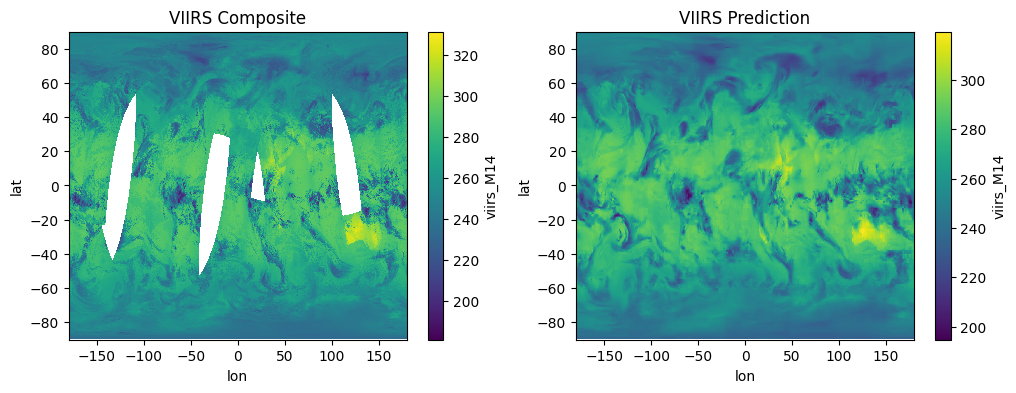

In [7]:
fig, axs = plt.subplots(1,2,figsize=(12,4))
axs = axs.flatten()

ds.viirs_M14.mean('time').plot(ax=axs[0])
axs[0].set_title("VIIRS Composite")

pred['viirs_M14'].isel(time=11, band_M14=0).plot(ax=axs[1])
axs[1].set_title("VIIRS Prediction")
plt.show()

#pred['atms_brightness_temp'].isel(time=6, atms_channel=11).plot(cmap='jet')
#pred['atms_brightness_temp'].isel(time=6).sel(lat=30, method='nearest').plot(cmap='jet')
#(pred['srtm_elevation'].isel(band_elevation=0) > 5).plot(vmin=0)

## GOES

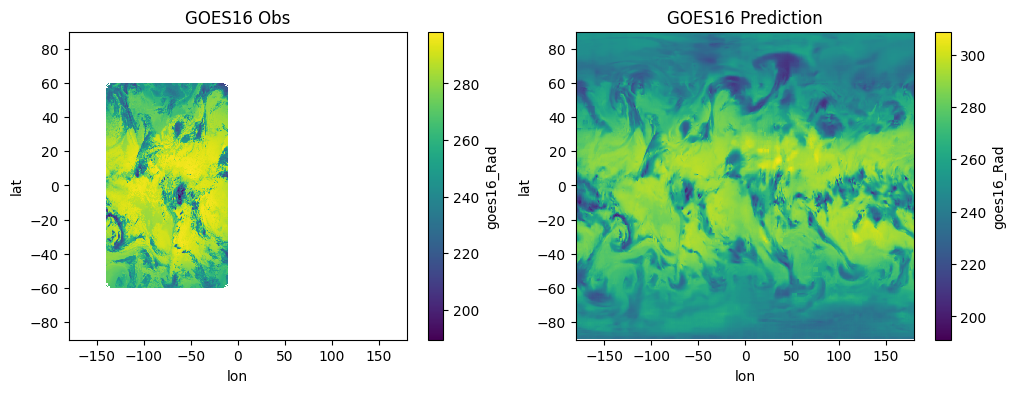

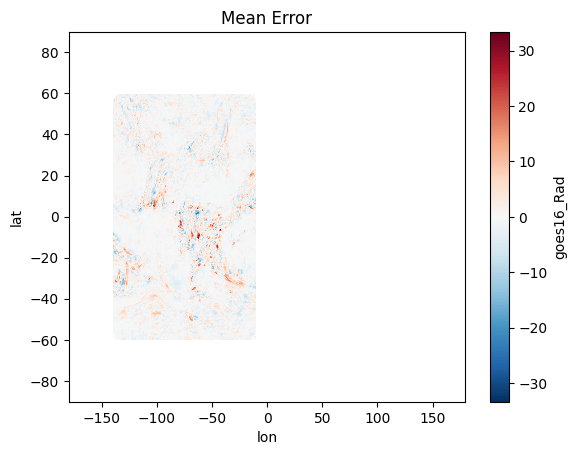

Bias: 0.07073974609375, MAE: 2.873046875


In [8]:
# diff = pred['goes18_Rad'].isel(time=6, goes18_band=9) - pred['goes16_Rad'].isel(time=6, goes16_band=9)
goes_band = 14

fig, axs = plt.subplots(1,2,figsize=(12,4))
axs = axs.flatten()

ds['goes16_Rad'].sel(goes16_band=goes_band).isel(time=11).plot(ax=axs[0])
axs[0].set_title("GOES16 Obs")

pred['goes16_Rad'].sel(goes16_band=goes_band).isel(time=11).plot(ax=axs[1])
axs[1].set_title("GOES16 Prediction")

plt.show()

diff = (pred['goes16_Rad'] - ds['goes16_Rad'])
diff.sel(goes16_band=goes_band).mean('time').plot()
plt.title("Mean Error")
plt.show()

flat = diff.values.flatten()
flat = flat[np.isfinite(flat)]

bias = np.mean(flat)
mae = np.mean(np.abs(flat))

print(f"Bias: {bias}, MAE: {mae}")


## ATMS

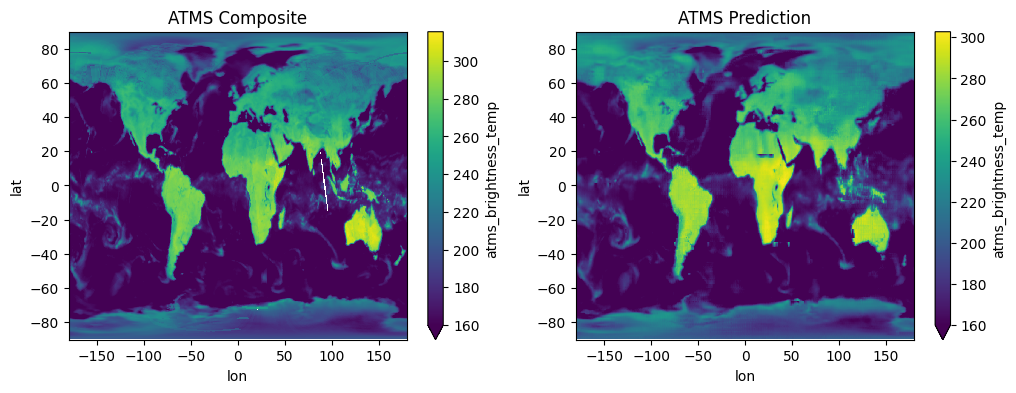

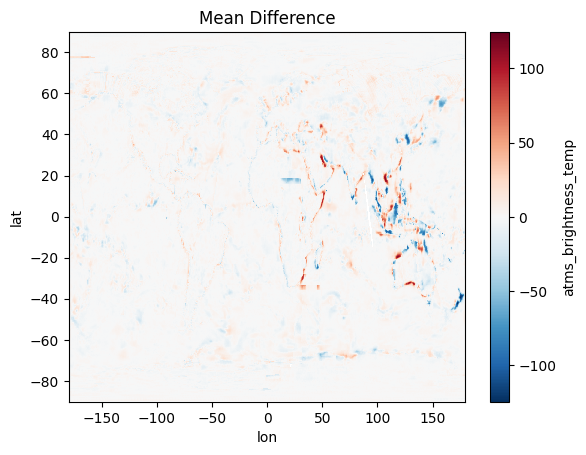

Bias: 0.0230712890625, MAE: 3.15625


In [9]:
atms_channel = 1

fig, axs = plt.subplots(1,2,figsize=(12,4))
axs = axs.flatten()

ds.atms_brightness_temp.isel(atms_channel=atms_channel).mean('time').plot(vmin=160, ax=axs[0])
axs[0].set_title("ATMS Composite")


pred['atms_brightness_temp'].isel(atms_channel=atms_channel).isel(time=11).plot(vmin=160, ax=axs[1])
axs[1].set_title("ATMS Prediction")
plt.show()



diff = (pred['atms_brightness_temp'] - ds['atms_brightness_temp'])
diff.mean('time').isel(atms_channel=atms_channel).plot()
plt.title("Mean Difference")
plt.show()

#diff.plot.hist(bins=200, range=(-10, 10))
#plt.show()

flat = diff.isel(atms_channel=atms_channel).values.flatten()
flat = flat[np.isfinite(flat)]

bias = np.mean(flat,)
mae = np.mean(np.abs(flat))

print(f"Bias: {bias}, MAE: {mae}")


## MiRS Vapor

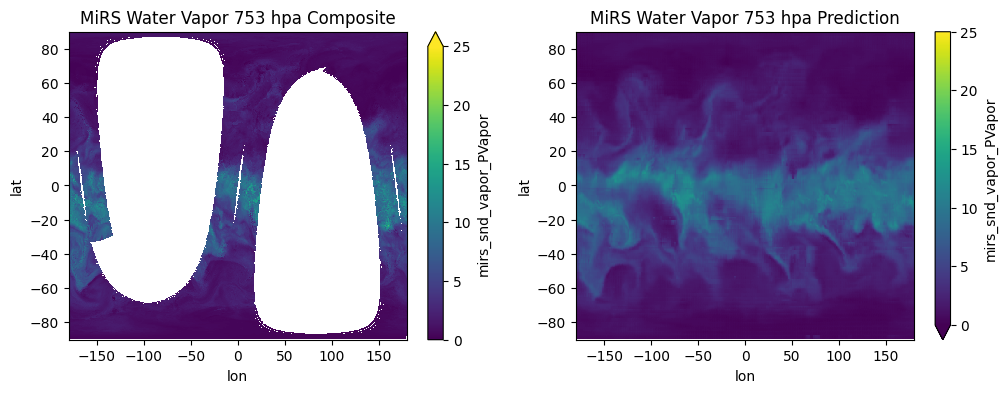

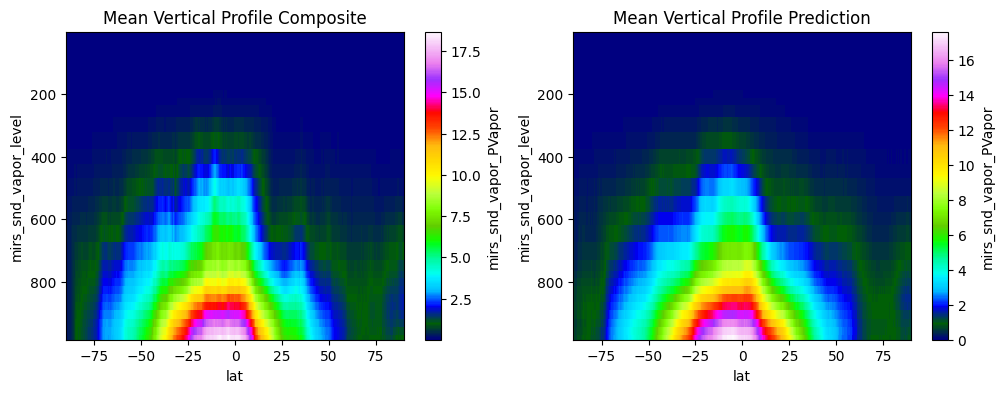

In [10]:
fig, axs = plt.subplots(1,2,figsize=(12,4))
axs = axs.flatten()

level = 10
hpa = int(ds.mirs_snd_vapor_level.values[level])
ds.mirs_snd_vapor_PVapor.isel(mirs_snd_vapor_level=level).mean('time').plot(vmin=0, vmax=25, ax=axs[0])
axs[0].set_title(f"MiRS Water Vapor {hpa} hpa Composite")

pred['mirs_snd_vapor_PVapor'].isel(mirs_snd_vapor_level=level).isel(time=11).plot(vmin=0, vmax=25, ax=axs[1])
axs[1].set_title(f"MiRS Water Vapor {hpa} hpa Prediction")
plt.show()


#diff = (pred['mirs_snd_vapor_PVapor'] - ds['mirs_snd_vapor_PVapor'])
#diff.mean('time').isel(mirs_snd_vapor_level=5).plot()
#plt.show()


fig, axs = plt.subplots(1,2,figsize=(12,4))
axs = axs.flatten()

ds['mirs_snd_vapor_PVapor'].mean('lon').mean('time').plot(yincrease=False, cmap='gist_ncar', ax=axs[0])
axs[0].set_title("Mean Vertical Profile Composite")

pred['mirs_snd_vapor_PVapor'].mean('time').mean('lon').plot(vmin=0, yincrease=False, cmap='gist_ncar', ax=axs[1])
axs[1].set_title("Mean Vertical Profile Prediction")
plt.show()

## MiRS Temp

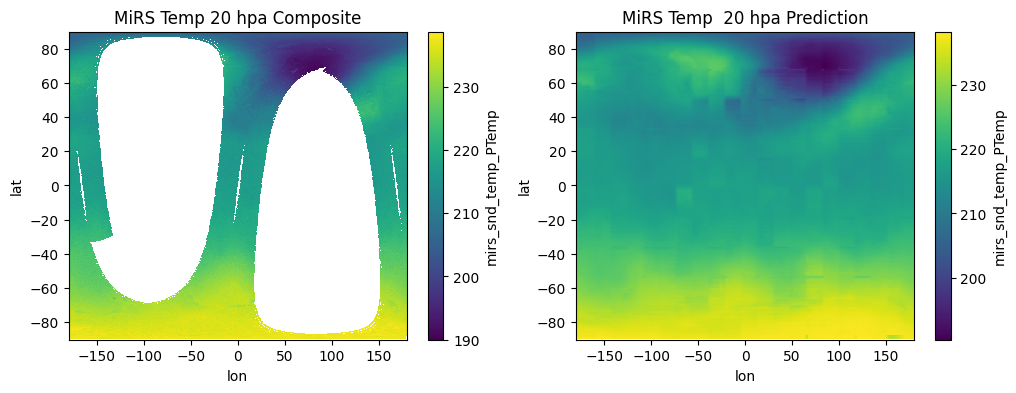

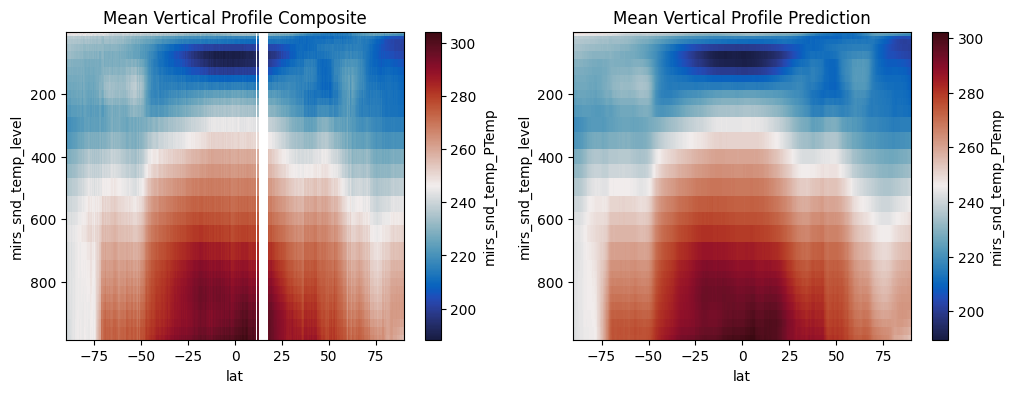

In [11]:
fig, axs = plt.subplots(1,2,figsize=(12,4))
axs = axs.flatten()

level = 30
hpa = int(ds.mirs_snd_vapor_level.values[level])

ds['mirs_snd_temp_PTemp'] = ds['mirs_snd_temp_PTemp'].astype(np.float32)
pred['mirs_snd_temp_PTemp'] = pred['mirs_snd_temp_PTemp'].astype(np.float32)

ds.mirs_snd_temp_PTemp.isel(mirs_snd_temp_level=level).mean('time').plot(ax=axs[0])
axs[0].set_title(f"MiRS Temp {hpa} hpa Composite")

pred['mirs_snd_temp_PTemp'].isel(mirs_snd_temp_level=level).isel(time=5).plot(ax=axs[1])
axs[1].set_title(f"MiRS Temp  {hpa} hpa Prediction")
plt.show()


#diff = (pred['mirs_snd_temp_PTemp'] - ds['mirs_snd_temp_PTemp'])
#diff.mean('time').isel(mirs_snd_temp_level=5).plot()
#plt.show()

fig, axs = plt.subplots(1,2,figsize=(12,4))
axs = axs.flatten()

#ds['mirs_snd_temp_PTemp'].mean('lon').mean('time').plot(yincrease=False, cmap='balance', ax=axs[0])
ds['mirs_snd_temp_PTemp'].sel(lon=5, method='nearest').mean('time').plot(yincrease=False, cmap='balance', ax=axs[0])
axs[0].set_title("Mean Vertical Profile Composite")

#pred['mirs_snd_temp_PTemp'].mean('lon').mean('time').plot(yincrease=False, cmap='balance', ax=axs[1])
pred['mirs_snd_temp_PTemp'].sel(lon=5, method='nearest').mean('time').plot(yincrease=False, cmap='balance', ax=axs[1])
axs[1].set_title("Mean Vertical Profile Prediction")
plt.show()



## MiRS Surface Vars

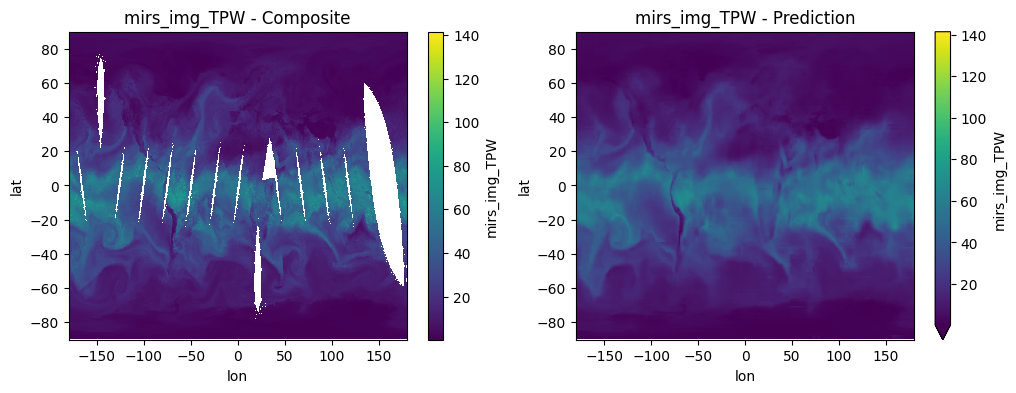

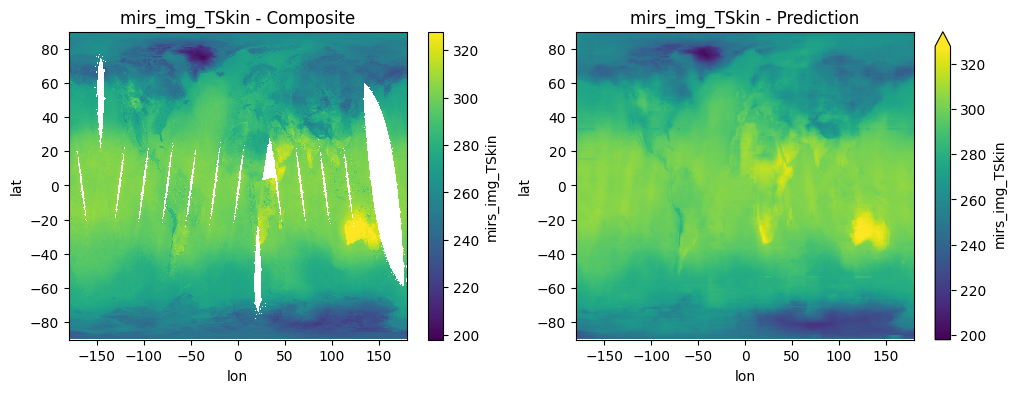

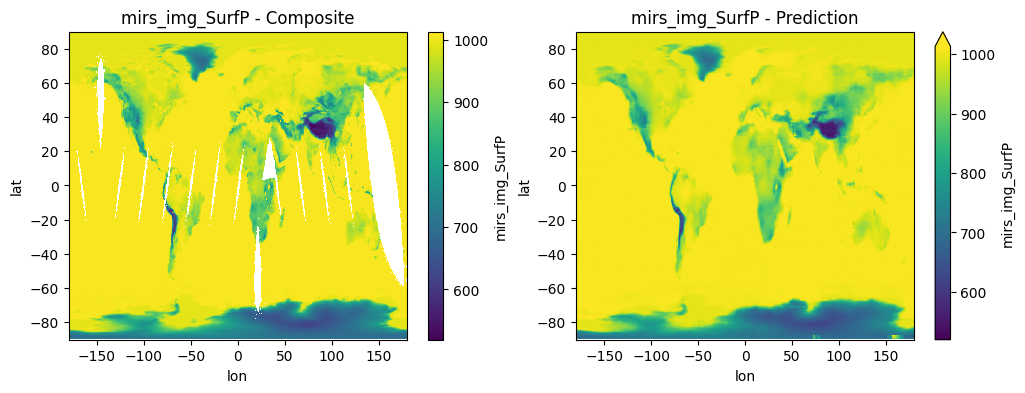

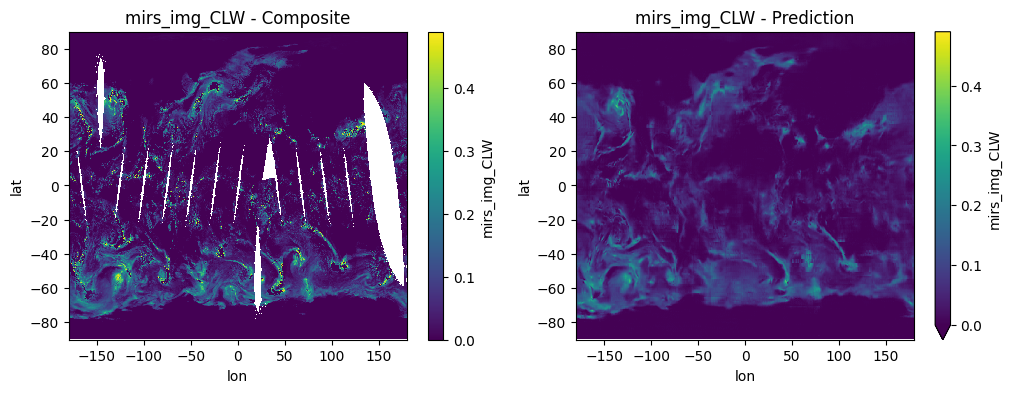

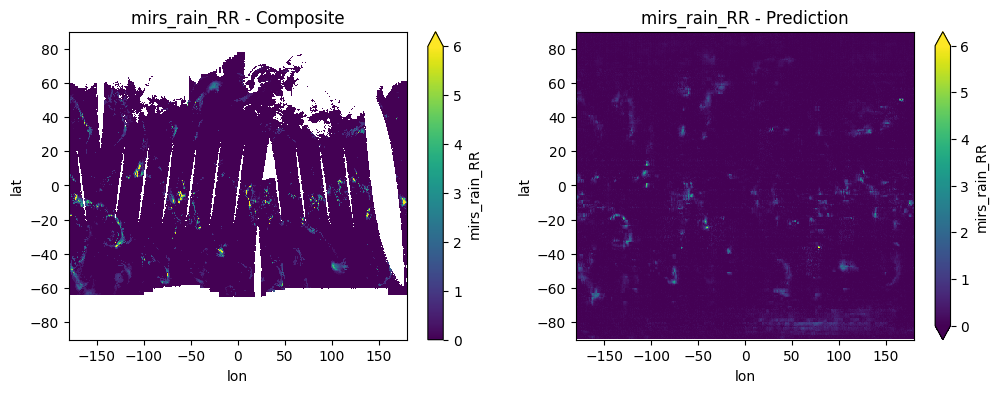

In [12]:

vss = ['mirs_img_TPW', 'mirs_img_TSkin', 'mirs_img_SurfP', 'mirs_img_CLW', 'mirs_rain_RR']

plot_kwargs = {'mirs_rain_RR': {'vmin': 0, 'vmax': 6}}

for v in vss:
    fig, axs = plt.subplots(1,2,figsize=(12,4))
    axs = axs.flatten()
    ds_v_mu = ds[v].mean('time')
    vmin = ds_v_mu.min().compute()
    vmax = ds_v_mu.max().compute()
    
    if v in plot_kwargs:
        if 'vmin' in plot_kwargs[v]:
            vmin = plot_kwargs[v]['vmin']
        if 'vmax' in plot_kwargs[v]:
            vmax = plot_kwargs[v]['vmax']
            
    ds_v_mu.plot(vmin=vmin, vmax=vmax, ax=axs[0])
    pred[v].isel(time=11).plot(vmin=vmin, vmax=vmax, ax=axs[1])
    axs[0].set_title(f"{v} - Composite")
    axs[1].set_title(f"{v} - Prediction")
    plt.show()
    